In [26]:
import numpy as np
import cv2
import os
import glob 
#img_dir zmenit podla toho kde sa nachadza dbs obrazkov
img_dir = "D:/school/BIO1/CelebA-small" # Enter Directory of all images
data_path = os.path.join(img_dir, '*g')
files = glob.glob(data_path)
name = ""
data = {}

for f1 in files[:5]:
    #print(f1)
    name = f1.split('\\')[1].strip()
    img = cv2.imread(f1)
    data[name] = img
 

import re

truth={}
with open('list_bbox_celeba.txt', 'r') as f:
    lines = f.readlines()[2:]    
    # vymazanie whitespaces
for line in lines:
    line = re.sub(' +', ';', line[:-1])
    truthpole=line.split(";")
    truth[truthpole[0]] = list(map(int, truthpole[1:]))

In [29]:
import matplotlib.pyplot as plt
import dlib 
import pandas as pd
from skimage.feature import hog
from collections import namedtuple
hogFaceDetector = dlib.get_frontal_face_detector()
cnn_face_detector = dlib.cnn_face_detection_model_v1('./mmod_human_face_detector.dat')
evaluation_table_hog = []
evaluation_table_cnn = []
iou_table_hog = []
iou_table_cnn = []

for key in data:
    img = data[key]  
    truthBox = truth[key]
    
    faceRects = None
    faceRects2 = None
    x11 = y11 = x12 = y12 = 0
    x21 = y21 = x22 = y22 = 0
    faceRects = hogFaceDetector(img, 1)
    faceRects2 = cnn_face_detector(img, 1)


    for faceRect in faceRects:
        x11 = faceRect.left()
        y11 = faceRect.top()
        x12 = faceRect.right()
        y12 = faceRect.bottom()
        
        # draw box over face      
        cv2.rectangle(img, (x11,y11), (x12,y12), (0,255,0), 2)

    for faceRect2 in faceRects2:
        x21 = faceRect2.rect.left()
        y21 = faceRect2.rect.top()
        x22 = faceRect2.rect.right()
        y22 = faceRect2.rect.bottom()

        #draw box over face
        cv2.rectangle(img, (x21,y21), (x22,y22), (255,0,0), 2)
   
    # draw truth box
    cv2.rectangle(img, (truthBox[0],truthBox[1]), (truthBox[0]+truthBox[2],truthBox[1]+truthBox[3]), (0,0,255), 2)
    
    #calc for hog
    xAhog = max(x11, truthBox[0])
    yAhog = max(y11, truthBox[1])
    xBhog = min(x12, truthBox[0]+truthBox[2])
    yBhog = min(y12, truthBox[1]+truthBox[3])    
    
    interAreaHog = max(0, xBhog - xAhog + 1) * max(0, yBhog - yAhog + 1)
    
    boxAreaHOG = (x12 - x11 + 1) * (y12 - y11 + 1)
        
    #calc for cnn
    xAcnn = max(x21, truthBox[0])
    yAcnn = max(y21, truthBox[1])
    xBcnn = min(x22, truthBox[0]+truthBox[2])
    yBcnn = min(y22, truthBox[1]+truthBox[3])    
    
    interAreaCNN = max(0, xBcnn - xAcnn + 1) * max(0, yBcnn - yAcnn + 1)
    
    boxAreaCNN = (x22 - x21 + 1) * (y22 - y21 + 1)
    
    boxTruth = (truthBox[2] + 1) * (truthBox[3] + 1)
    
    
    if x11 == 0 and y11 == 0 and x12 == 0 and y12 == 0:
        iouHOG = 0
    else:
        iouHOG = interAreaHog / float(boxAreaHOG + boxTruth - interAreaHog)
        
    if x21 == 0 and y21 == 0 and x22 == 0 and y22 == 0:
        iouCNN = 0
    else:
        iouCNN = interAreaCNN / float(boxAreaCNN + boxTruth - interAreaCNN)
        
    if iouHOG >= 0.5:
        evaluation_table_hog.append("TP")
    elif iouHOG != 0:
        evaluation_table_hog.append("FP")
    else:
        evaluation_table_hog.append("FN")
    
    if iouCNN >= 0.5:     
        evaluation_table_cnn.append("TP")
    elif iouCNN != 0:
        evaluation_table_cnn.append("FP")
    else:
        evaluation_table_cnn.append("FN")
    
    iou_table_cnn.append(iouCNN)
    iou_table_hog.append(iouHOG)
    img_height, img_width = img.shape[:2]
    cv2.putText(img, "Truth", (img_width-120,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
    cv2.putText(img, "CNN", (img_width-80,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    cv2.putText(img, "HOG", (img_width-40,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) 
    cv2.putText(img, "IoU HOG: {:.4f}".format(iouHOG), (img_width-150, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (180, 180, 0), 2)
    cv2.putText(img, "IoU CNN: {:.4f}".format(iouCNN), (img_width-150, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
    cv2.imshow("face detection with dlib " + key, img)
    cv2.waitKey(500)
    
cv2.destroyAllWindows()

In [9]:
import pandas as pd
iouulozHog= pd.DataFrame()
iouulozCNN = pd.DataFrame()
iouulozHog["iouHog"]= iou_table_hog
iouulozCNN["iouCNN"]= iou_table_cnn
iouulozHog["evaltable"] = evaluation_table_hog
iouulozCNN["evaltableCNN"] = evaluation_table_cnn
iouulozCNN.to_csv("iouulozCNN.csv")
iouulozHog.to_csv("iouulozHog.csv")

In [20]:
precisionHOG = []
recallHOG = []
precisionCNN = []
recallCNN = []
TPHog=FPHog=FNHog=0
TPCNN=FPCNN=FNCNN=0

FNHog = sum(1 for i in evaluation_table_hog if i == "FN") 
FNCNN = sum(1 for i in evaluation_table_cnn if i == "FN") 

for i in range(len(iou_table_hog)):     
    
    if iou_table_hog[i] > 0.5:
        TPHog =TPHog+1
    else:
        FPHog =FPHog+1    
        
    if iou_table_cnn[i] > 0.5:
        TPCNN = TPCNN+1
    else:
        FPCNN =FPCNN+1   
    
    try:
        APHOG = TPHog/(TPHog+FPHog)
        RecHOG = TPHog/(TPHog+FNHog)        
    except ZeroDivisionError:
        APHOG = RecHOG = 0.0
        
    try:
        APCNN = TPCNN/(TPCNN+FPCNN)
        RecCNN =TPCNN/(TPCNN+FNCNN) 
    except ZeroDivisionError:
        APCNN = RecCNN = 0.0
    
    precisionHOG.append(APHOG)
    precisionCNN.append(APCNN)
    recallHOG.append(RecHOG)
    recallCNN.append(RecCNN)

In [21]:
dataframeHog=pd.DataFrame()
dataframeCNN=pd.DataFrame()

dataframeHog["precision"]=precisionHOG
dataframeHog["recall"]=recallHOG
dataframeCNN["precision"]=precisionCNN
dataframeCNN["recall"]=recallCNN

dataframeHog['IntPrec'] = dataframeHog.groupby('recall')['precision'].transform('max')
dataframeCNN['IntPrec'] = dataframeCNN.groupby('recall')['precision'].transform('max')


dataframeHog.to_csv('dataHog.csv')
dataframeCNN.to_csv('dataCNN.csv')

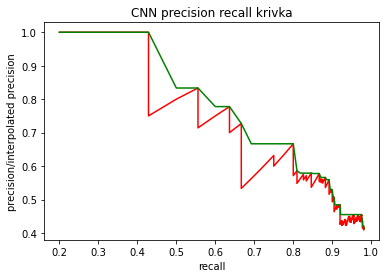

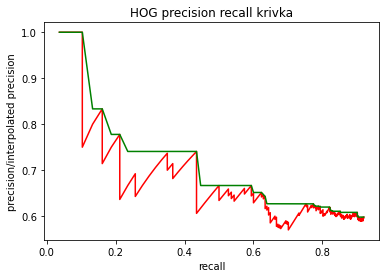

In [22]:
import matplotlib.pyplot as plt 
displayHog = []
for i in range(len(dataframeHog['IntPrec'])):
    displayHog.append(max(dataframeHog['IntPrec'][i:]))

dataframeHog['IntDisplay'] = displayHog

displayCNN = []
for i in range(len(dataframeCNN['IntPrec'])):
    displayCNN.append(max(dataframeCNN['IntPrec'][i:]))

dataframeCNN['IntDisplay'] = displayCNN

plt.plot(dataframeCNN['recall'],dataframeCNN['precision'],'r')
plt.plot(dataframeCNN['recall'],dataframeCNN['IntDisplay'],'g')
plt.xlabel('recall') 
plt.ylabel('precision/interpolated precision') 
plt.title('CNN precision recall krivka') 
plt.show()

dataframeHog['IntDisplay'] = displayHog
plt.plot(dataframeHog['recall'],dataframeHog['precision'],'r')
plt.plot(dataframeHog['recall'],dataframeHog['IntDisplay'],'g')
plt.xlabel('recall') 
plt.ylabel('precision/interpolated precision') 
plt.title('HOG precision recall krivka') 
plt.show()

In [23]:
precRecHog = []

for recall_level in np.linspace(0.0, 1.0, 11):
    try:
        x = dataframeHog[dataframeHog['recall'] >= recall_level]['IntPrec']
        prec = max(x)
    except:
        prec = 0.0
    precRecHog.append(prec)
avg_prec = np.mean(precRecHog)
print('11 point precision is ', precRecHog)
print('mAP for Hog is ', avg_prec)

precRecCNN = []

for recall_level2 in np.linspace(0.0, 1.0, 11):
    try:
        x = dataframeCNN[dataframeCNN['recall'] >= recall_level2]['IntPrec']
        precCNN = max(x)
    except:
        precCNN = 0.0
    precRecCNN.append(precCNN)
avg_prec = np.mean(precRecCNN)
print('11 point precision is ', precRecCNN)
print('mAP for CNN is ', avg_prec)

11 point precision is  [1.0, 1.0, 0.7777777777777778, 0.7407407407407407, 0.7407407407407407, 0.6666666666666666, 0.6515151515151515, 0.626984126984127, 0.6197916666666666, 0.6082474226804123, 0.0]
mAP for Hog is  0.6756785721611167
11 point precision is  [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7777777777777778, 0.6666666666666666, 0.6666666666666666, 0.5294117647058824, 0.0]
mAP for CNN is  0.7703505644682115


In [ ]:
#============================================================================
# tuto celu spustit v pripade ze sa vsetko dodrbe v csv su ulozene dataframes
dataframeCNN = pd.read_csv('dataCNN.csv')  
dataframeHog = pd.read_csv('dataHog.csv')
#============================================================================   

In [24]:
import re
predicted={}
with open('list_landmarks_celeba.txt', 'r') as f:
    lines = f.readlines()[2:]  

for line in lines:
    line = re.sub(' +', ';', line[:-1])
    predictedPole =line.split(";")
    predicted[predictedPole[0]] = list(map(int, predictedPole[1:]))
    

In [25]:
from itertools import islice
desiredLeftEye=(0.38, 0.38)

for key in data:
    img = data[key]  
    coordinates = predicted[key]
    leftEyeX,leftEyeY = coordinates[0],coordinates[1]
    rightEyeX,rightEyeY =coordinates[2],coordinates[3]
    
    dY = rightEyeY - leftEyeY
    dX = rightEyeX - leftEyeX
    
    angle = np.degrees(np.arctan2(dY, dX))
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= 300 #256pixelov
    scale = desiredDist / dist
    eyesCenter = ((leftEyeX + rightEyeX) // 2,(leftEyeY + rightEyeY) // 2)
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    tX = 300 * 0.5
    tY = 300 * desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
    (w, h) = (300, 300)
    output = cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC)
    cv2.imshow("Original", img)
    cv2.imshow("Aligned", output)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

In [ ]:
import sys
import dlib
import cv2

detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('./mmod_human_face_detector.dat')

cam = cv2.VideoCapture(0)

while True:
    ret_val, img = cam.read()
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detsHog = detector(rgb_image, 1)
    detsCNN = cnn_detector(rgb_image, 1)
    for det in detsHog:
        cv2.rectangle(img,(det.left(), det.top()), (det.right(), det.bottom()), (0,255,0), 2)
    for det in detsCNN:
        cv2.rectangle(img,(det.rect.left(), det.rect.top()), (det.rect.right(), det.rect.bottom()), (255,0,0), 2)
    cv2.imshow('my webcam', img)
    if cv2.waitKey(1) == 27:
        break  # esc to quit
cv2.destroyAllWindows()